In [1]:
import numpy as np
import pandas as pd
from pyDOE import lhs  # Latin Hypercube Sampling
from scipy.optimize import newton
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import GroupShuffleSplit


# Ensure reproducibility'
np.random.seed(42)
#tf.random.set_seed(42)
tf.random.set_random_seed(42)

# Material constants
E = 193000e6  # Young's modulus in MPa
sigma_y = 150e6  # Yield stress in MPa
c1, c2, c3 = 230000e6, 19600e6, 1800e6  # Kinematic hardening constants
gamma1, gamma2, gamma3 = 1200, 140, 4  # Hardening constants
b = 8  # Isotropic hardening rate
Q = 110e6  # Isotropic hardening saturation value



# Generate strain history byappointment islamabad accumulating increments
def generate_strain_history(num_samples, lb, ub):
    strain_history = np.zeros(num_samples)
    cumulative_strain = 0  # Start with zero cumulative strain

    # First range: Accumulate small positive strain increments
    for i in range(300):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    # Second range: Accumulate negative strain increments
    for i in range(300, 900):
        increment = np.random.uniform(lb, ub)
        cumulative_strain -= increment
        strain_history[i] = cumulative_strain

    # Third range: Return to positive strain increments
    for i in range(900, num_samples):
        increment = np.random.uniform(lb, ub)
        cumulative_strain += increment
        strain_history[i] = cumulative_strain

    return strain_history



# Hooke's law (elastic predictor)
def elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y):
    sigma_trial = E * (eps - eps_p)  # Trial stress
    back_stress = sigma_k1 + sigma_k2 + sigma_k3
    yield_function = np.abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
    return sigma_trial, yield_function

# Update kinematic hardening rule
def update_kinematic_hardening(sigma_k, eps_p_dot, c, gamma):
    return (2.0 / 3.0) * c * eps_p_dot - gamma * sigma_k * abs(eps_p_dot)

# Update isotropic hardening rule
def update_isotropic_hardening(sigma_i, eps_p_dot, b, Q):
    return b * (Q - sigma_i) * abs(eps_p_dot)

# Return mapping algorithm
def return_mapping(eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y):
    if yield_function <= 0:
        # Elastic step
        return sigma_trial, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
    else:
        # Plastic corrector step
        def plastic_residual(delta_gamma):
            eps_p_dot = delta_gamma
            back_stress = sigma_k1 + sigma_k2 + sigma_k3
            sigma_updated = sigma_trial - E * delta_gamma
            yield_function_updated = np.abs(sigma_updated - back_stress) - (sigma_y + sigma_i + b * delta_gamma)
            return yield_function_updated

        try:
            delta_gamma = newton(plastic_residual, 1e-5, tol=1e-8, maxiter=50)  # Solve for plastic multiplier
        except RuntimeError:
            delta_gamma = 0.0  # If Newton-Raphson fails, assume no plastic deformation

        eps_p += delta_gamma
        sigma_k1 += update_kinematic_hardening(sigma_k1, delta_gamma, c1, gamma1)
        sigma_k2 += update_kinematic_hardening(sigma_k2, delta_gamma, c2, gamma2)
        sigma_k3 += update_kinematic_hardening(sigma_k3, delta_gamma, c3, gamma3)
        sigma_i += update_isotropic_hardening(sigma_i, delta_gamma, b, Q)

        # Final stress update
        sigma_updated = sigma_trial - E * delta_gamma
        return sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i


# Generate dataset
def generate_dataset(lb, ub, num_strain_samples):
    dataset = []
    strain_history = generate_strain_history(num_strain_samples, lb, ub)

    # Initialize state variables
    sigma_k1, sigma_k2, sigma_k3, sigma_i, eps_p = 0, 0, 0, 0, 0

    for eps in strain_history:
        # Elastic predictor
        sigma_trial, yield_function = elastic_predictor(eps, eps_p, E, sigma_k1, sigma_k2, sigma_k3, sigma_i, sigma_y)

        # Return mapping algorithm
        sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i = return_mapping(
            eps, eps_p, sigma_trial, yield_function, sigma_k1, sigma_k2, sigma_k3, sigma_i, E, sigma_y
        )

        # Store the data
        back_stress = sigma_k3 
        #trial_phi = abs(sigma_trial - back_stress) - (sigma_y + sigma_i)
        trial_phi=yield_function
        dataset.append([
            E, sigma_y, c1, gamma1, c2, gamma2, c3, gamma3, 
            b, Q, trial_phi, eps, sigma_updated, eps_p, sigma_k1, sigma_k2, sigma_k3, sigma_i
        ])

    return np.array(dataset)


# Save the dataset to a CSV file
def save_dataset_to_csv(dataset, filename="generated_dataset_training20.11.csv"):
    columns = [E, sigma_y, c[0],gamma[0], c[1],gamma[1], c[2],gamma[2],
                b, Q, trial_phi,
                strain,          # Strain
                stress_rm,    # Stress from Return Mapping
                plastic_strain]
    df = pd.DataFrame(dataset, columns=columns)
    df.to_csv(filename, index=False)
    print(f"Dataset saved to {filename}")



In [2]:
training = generate_dataset(lb=0.0001,ub=0.0002, num_strain_samples=1500)
test1 = generate_dataset(lb=0,ub=0.0001, num_strain_samples=1500)
test2 = generate_dataset(lb=0.0002,ub=0.0004, num_strain_samples=1500)

In [3]:
columns = ['E', 'sigma_y', 'c[0]','gamma[0]', 'c[1]','gamma[1]', 'c[2]','gamma[2]','b', 'Q', 'trial_phi',
            'strain',          # Strain
            'stress_rm',    # Stress from Return Mapping
            'plastic_strain', 'sigma_k1', 'sigma_k2', 'sigma_k3', 'sigma_i']
df = pd.DataFrame(training, columns=columns)

In [4]:
df.tail(20)

,E,sigma_y,c[0],gamma[0],c[1],gamma[1],c[2],gamma[2],b,Q,trial_phi,strain,stress_rm,plastic_strain,sigma_k1,sigma_k2,sigma_k3,sigma_i
1480,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.491621e+07,0.043308,5.071053e+08,0.040681,1.277778e+08,9.333180e+07,4.671831e+07,8.949063e+07
1481,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.140685e+07,0.043420,5.073185e+08,0.040792,1.277778e+08,9.333182e+07,4.683069e+07,8.950883e+07
1482,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.967804e+07,0.043575,5.074491e+08,0.040946,1.277778e+08,9.333185e+07,4.698641e+07,8.953404e+07
1483,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,1.923018e+07,0.043675,5.076301e+08,0.041045,1.277778e+08,9.333187e+07,4.708725e+07,8.955035e+07
1484,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.544733e+07,0.043808,5.077472e+08,0.041177,1.277778e+08,9.333190e+07,4.722064e+07,8.957192e+07
1485,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.621772e+07,0.043945,5.079022e+08,0.041313,1.277778e+08,9.333193e+07,4.735799e+07,8.959412e+07
1486,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.678655e+07,0.044084,5.080618e+08,0.041452,1.277778e+08,9.333196e+07,4.749825e+07,8.961678e+07
1487,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,3.255958e+07,0.044254,5.082248e+08,0.041620,1.277778e+08,9.333199e+07,4.766864e+07,8.964429e+07
1488,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.660124e+07,0.044393,5.084227e+08,0.041758,1.277778e+08,9.333201e+07,4.780775e+07,8.966673e+07
1489,1.930000e+11,150000000.0,2.300000e+11,1200.0,1.960000e+10,140.0,1.800000e+09,4.0,8.0,110000000.0,2.779820e+07,0.044537,5.085843e+08,0.041902,1.277778e+08,9.333204e+07,4.795305e+07,8.969016e+07


In [5]:
strain_training= training[:,11]
strain_test1= test1[:,11]
strain_test2= test2[:,11]

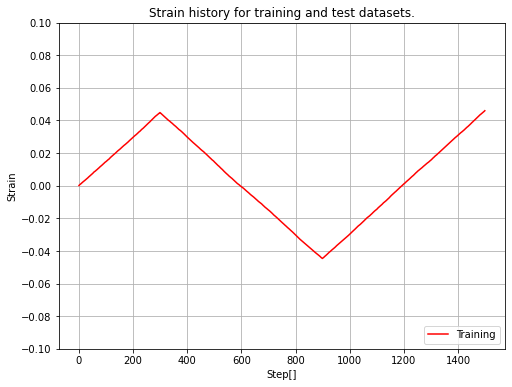

In [6]:
plt.figure(figsize=(8, 6))
plt.plot(strain_training, label='Training', color='red')
#plt.plot(strain_test1, label='Test1', color='blue')
#plt.plot(strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Strain')
plt.title('Strain history for training and test datasets.')

y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [7]:
plastic_strain_training= training[:,13]
plastic_strain_test1= test1[:,-1]
plastic_strain_test2= test2[:,-1]

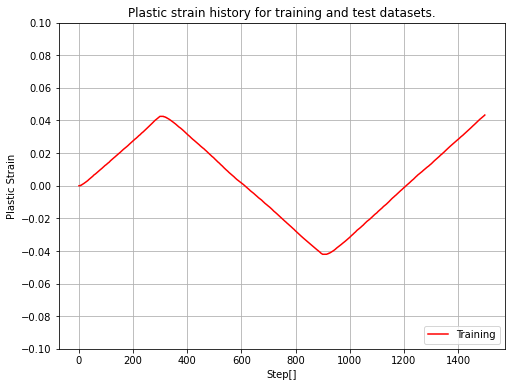

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(plastic_strain_training, label='Training', color='red')
#plt.plot(plastic_strain_test1, label='Test1', color='blue')
#plt.plot(plastic_strain_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Plastic Strain')
plt.title('Plastic strain history for training and test datasets.')

y_ticks = np.arange(-0.1, 0.11, 0.02)  # Values from -0.1 to 0.1 with a step of 0.02
plt.yticks(y_ticks)

plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [9]:
stress_rm_training= training[:,14]
stress_rm_test1= test1[:,-2]
stress_rm_test2= test2[:,-2]

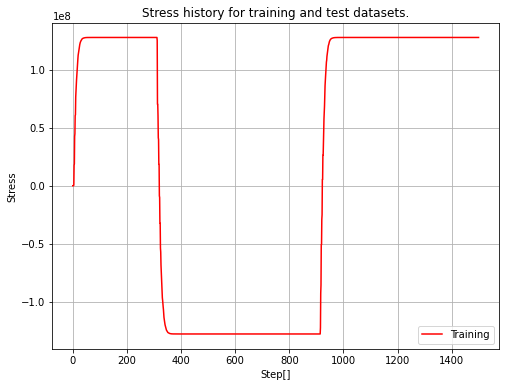

In [10]:
plt.figure(figsize=(8, 6))
plt.plot(stress_rm_training, label='Training', color='red')
#plt.plot(stress_rm_test1, label='Test1', color='blue')
#plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Stress')
plt.title('Stress history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

In [11]:
trail_phi_training= training[:,10]
trail_phi_test1= test1[:,10]
trail_phi_test2= test2[:,10]

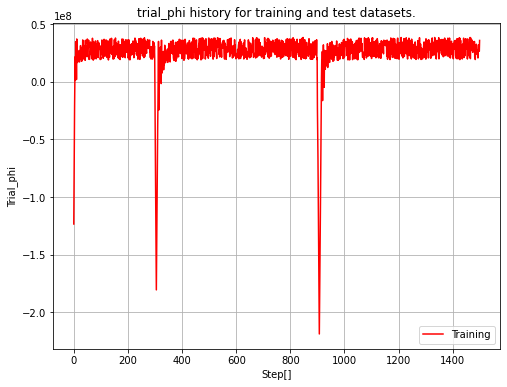

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(trail_phi_training, label='Training', color='red')
#plt.plot(trail_phi_test1, label='Test1', color='blue')
#plt.plot(trail_phi_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('Trial_phi')
plt.title('trial_phi history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

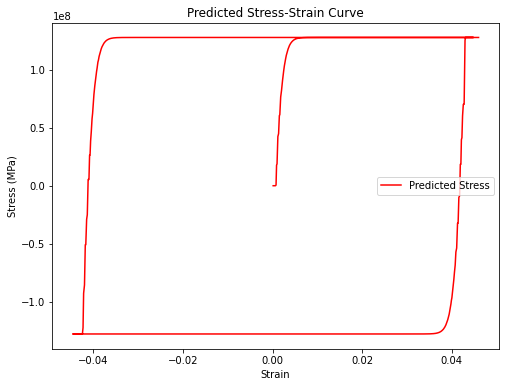

In [13]:
# Plot predicted stress vs strain
plt.figure(figsize=(8, 6))
plt.plot(strain_training, training[:,14], label='Predicted Stress', color='red')
#plt.plot(strain_values_test, df_test['stress_rm'], label='Actual Stress', color='blue')
plt.xlabel('Strain')
plt.ylabel('Stress (MPa)')
plt.title('Predicted Stress-Strain Curve')
plt.legend()

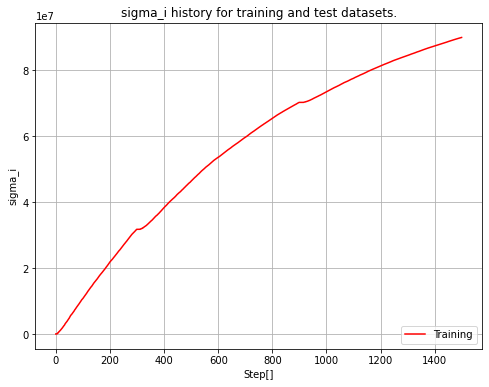

In [14]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,-1], label='Training', color='red')
#plt.plot(stress_rm_test1, label='Test1', color='blue')
#plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('sigma_i')
plt.title('sigma_i history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

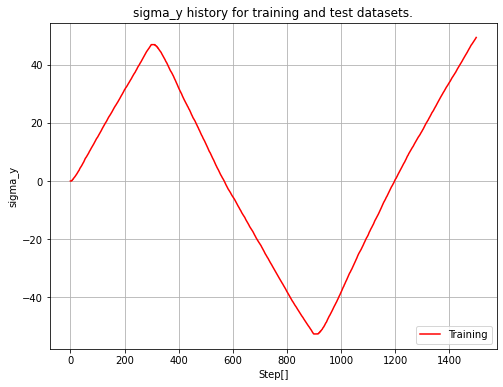

In [71]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,-2], label='Training', color='red')
#plt.plot(stress_rm_test1, label='Test1', color='blue')
#plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('sigma_y')
plt.title('sigma_y history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

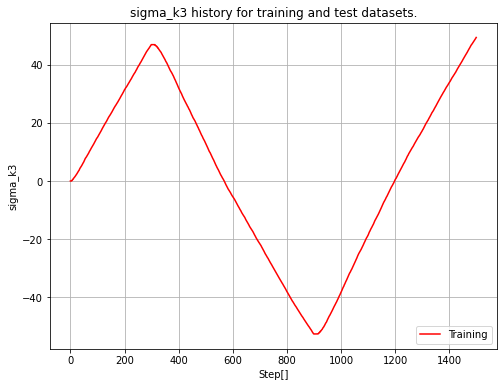

In [72]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,-2], label='Training', color='red')
#plt.plot(stress_rm_test1, label='Test1', color='blue')
#plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('sigma_k3')
plt.title('sigma_k3 history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

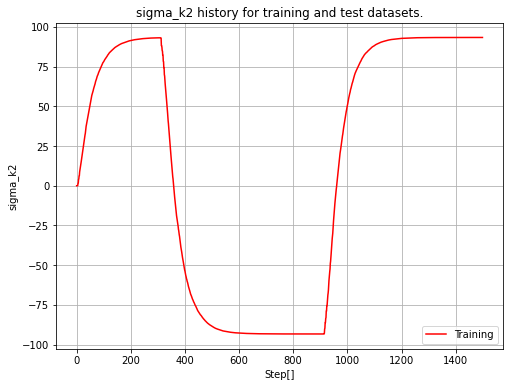

In [73]:
plt.figure(figsize=(8, 6))
plt.plot(training[:,-3], label='Training', color='red')
#plt.plot(stress_rm_test1, label='Test1', color='blue')
#plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('sigma_k2')
plt.title('sigma_k2 history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()

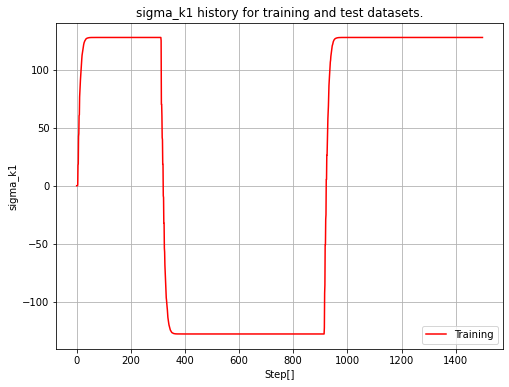

In [74]:

plt.figure(figsize=(8, 6))
plt.plot(training[:,-4], label='Training', color='red')
#plt.plot(stress_rm_test1, label='Test1', color='blue')
#plt.plot(stress_rm_test2, label='Test2', color='green')
plt.xlabel('Step[]')
plt.ylabel('sigma_k1')
plt.title('sigma_k1 history for training and test datasets.')
plt.legend(loc="lower right") 
plt.grid(True)
plt.show()